# New approach, find lines with correct format (with thanks to David Kane at https://github.com/drkane)

Find correct sheets by finding those titled "Balance Sheet"

Exclude a bunch of false positives by filtering out "Statement of" and "Note to the financial statements"

Detect aligned elements by whitespace

within concatenated elements, detect values by regex

if needed, complete multi-line label by finding correct aggregated sentence in blocks / pars

## Discovered bugs to fix

- on example 0542515, giving weird results with numbers in label, not separating lines? and not reading labels that extend over a line AFTER the value.

- on example 1539777, variables labelled "Date", "Note", needs cleaning out.

- on example 0030177, variable labels incomplete, lots of variables with names that continue on to next line?

In [1]:
import numpy as np
import pandas as pd
import os
import re
import importlib

import xbrl_image_parser as xip

# ------------- Just For Plotting Pages ------------------ #
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.path import Path
from matplotlib.patches import PathPatch

from imageio import imread

## 0.  Example usage, calling the main function from the library
The rest of the notebook goes through details of what it's doing...

In [36]:
importlib.reload(xip)
results = xip.process_PDF("./example_data_PDF/00002404.pdf")
results

Converting PDF image to multiple png files
./example_data_PDF/00002404.pdf
Performing pre-processing on all png images


Skipping line 172: Expected 12 fields in line 172, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


,conf,currYr,label,source,value,year,unit
0,93.0,1.0,Note,Note 000 000,000,2015.0,£000
1,0.0,0.0,Note,Note 000 000,000,2014.0,£000
2,95.0,1.0,Called up share capital,Called up share capital 21 5245 5245,5245,2015.0,£000
3,92.0,0.0,Called up share capital,Called up share capital 21 5245 5245,5245,2014.0,£000
4,96.0,1.0,Revaluation reserve .,Revaluation reserve . 20 1061 1061,1061,2015.0,£000
5,96.0,0.0,Revaluation reserve .,Revaluation reserve . 20 1061 1061,1061,2014.0,£000
6,96.0,1.0,Hedging reserve,Hedging reserve 20 677 566,677,2015.0,£000
7,96.0,0.0,Hedging reserve,Hedging reserve 20 677 566,566,2014.0,£000
8,96.0,1.0,Profit and loss account .,Profit and loss account 20 . 40951 33117,40951,2015.0,£000
9,95.0,0.0,Profit and loss account .,Profit and loss account 20 . 40951 33117,33117,2014.0,£000


## 1. Get the filenames of the example data for my convenience

In [3]:
# Get a list of all of the pdf files in the directory "CH_records"
files = [filename.split(".")[0] for filename in os.listdir("./working/ocr_output_compiled") if ".csv" in filename]

In [4]:
for each in range(len(files)):
    print(each, files[each])

0 00002404
1 868273
2 1983517
3 2765595
4 03293902
5 02959325
6 00542515
7 01539777
8 02714555
9 00030177
10 04802747
11 02266230
12 00983951
13 01002610
14 01804186
15 5508774
16 02430955
17 00053475
18 02245999
19 00553535
20 3387163
21 01337451
22 3459907
23 00178090
24 00468115
25 01369166
26 00782931
27 09457025
28 983951
29 01370175
30 06005142
31 04860660
32 2303730
33 02582534
34 00477955
35 04558828
36 06034603
37 3824626


## 2. Read in a csv file of data extracted from a PDF

In [5]:
# Rediscovering what works...
index=0

# So far can create all those extra geometric features, can convert to numeric
test = pd.read_csv("./working/ocr_output_compiled/"+files[index]+".csv")

In [12]:
# Create numeric vars where possible
test['numerical'] = xip.convert_to_numeric(test['text'])

# Do some geometry (eg; calculate bottom-bounding coordinates explicitly)
test = xip.make_measurements(test)

In [13]:
# Look at the first page of the balance sheet.  Some things to note; that first element is a bounding box
# for the entire page
test[test['csv_num']==14][['top', 'bottom', 'text', 'level', 'conf']]

,top,bottom,text,level,conf
5753,0,3509,NaN,1,-1
5754,156,250,NaN,2,-1
5755,156,250,NaN,3,-1
5756,156,250,NaN,4,-1
5757,156,250,©,5,93
5758,355,391,NaN,2,-1
5759,355,391,NaN,3,-1
5760,355,391,NaN,4,-1
5761,355,389,Best,5,96
5762,355,391,Execution,5,96


## 3. Identify balance sheet pages

In [14]:
csv_numbers = xip.find_balance_sheet_pages(test)
csv_numbers

[2.0, 17.0]

## 4.  Find lines on the balance sheet

In [65]:
importlib.reload(xip)
results = pd.DataFrame()

for csv_number in csv_numbers:
    
    page_df = test[test['csv_num']==csv_number]
    results = results.append( xip.extract_lines(page_df, xip.detect_lines(page_df)) )

results

oO
fe)
7s
a
m
Zz
a
n
Contents
Business Highlights
Chairman's Statement
Notice of Annual General Meeting
Financial Diary
Directors’ Report
Strategic Review
Profit and Loss Account
Balance Sheet
Cash Flow Statement
Risks & Uncertainties
Notes to the Accounts
Report of the Auditors
Statistical Review
ao
>
am
>
ra
Balance Sheet a m nm x m m
+
Balance Sheet as at 30 September 2016
WADWORTH and Company Limited | Notes 2016 2015
£000 £000; £000 £000
Failed to process line: 000 000 000 000
FIXED ASSETS
Intangible assets (8) 41 83
Tangible assets (9) 132,363 125,709
132,404 125,792
fo
CURRENT ASSETS
Stocks (10) 1,994 | 2,039
Debtors ay 4,232 4,519
Loans and unquoted investments
Cash at bank and in hand 539 1,611
6,901 8,333 CREDITORS: AMOUNTS FALLING DUE a3)| 11,342 | 8,006
WITHIN ONE YEAR
NET CURRENT ASSETS/(LIABILITIES) (4,441) 327
[TOTAL ASSETS LESS CURRENT LIABILITIES 127,963 126,119 |
CREDITORS: AMOUNTS FALLING DUE (14) 40,727 39,969
AFTER MORE THAN ONE YEAR
PROVISION FOR LIABILITIES AND C

,conf,currYr,label,source,value
0,95.0,1.0,WADWORTH and Company Limited Notes,WADWORTH and Company Limited Notes 2016 2015,2016
1,96.0,0.0,WADWORTH and Company Limited Notes,WADWORTH and Company Limited Notes 2016 2015,2015
2,96.0,1.0,Intangible assets,Intangible assets 8 41 83,41
3,52.0,0.0,Intangible assets,Intangible assets 8 41 83,83
4,96.0,1.0,Tangible assets,Tangible assets 9 132363 125709,132363
5,96.0,0.0,Tangible assets,Tangible assets 9 132363 125709,125709
6,17.0,1.0,Stocks,Stocks 10 1994 2039,1994
7,92.0,0.0,Stocks,Stocks 10 1994 2039,2039
8,96.0,1.0,Debtors ay,Debtors ay 4232 4519,4232
9,48.0,0.0,Debtors ay,Debtors ay 4232 4519,4519


## 5. Quick-fixes for weird problems

These'll no doubt accumulate

In [12]:
# a)  Drop any field labelled "Note", it's been read from the headers by accident
results = results[results['label'].isin(["Notes", "notes", "note", "Note"]) == False]

## 6. Extract the years and units from the document

In [22]:
# Find the years by counting 4-digit numbers and taking the most frequently occuring two
years = xip.determine_years_count(test)
years.max()

/home/martin/Documents/xbrl_parser/xbrl_image_parser.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


2015.0

In [24]:
# Find the reporting unit using a more complex regex to get the most common string
# that starts with a unit identifier like '£'
unit = xip.determine_units_count(test)
unit

/home/martin/Documents/xbrl_parser/xbrl_image_parser.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  subset['count'] = 1


('£000', 81)

## 7.  View a given page

In [5]:
# Figure out the ratio of whitespace in each block
# This is an old trick for finding sparse tables; find blocks with sparse text.
# Doesn't help much because Tesseract reads really sparse tables as multiple
# unconnected blocks.

def calculate_whitespace(data, threshold=0.8):
    
    # to hold calculated values
    whitespace = []
    block_num = []
    csv_num = []
    whitespace_frac = []
    whitespace_anomalous = []

    for csv in data['csv_num'].unique():
        for block in data[data['csv_num']==csv]['block_num'].unique():
            
            subset = data[(data['csv_num']==csv) & (data['block_num']==block)]      # Get the relevant data
            total_area = subset[subset['par_num']==0]['area'].sum()                 # Total area of block
            word_area = subset[subset['word_num'] > 0]['area'].sum()                # Total area occupied by words (assume rectangles)
            whitespace.append(total_area - word_area)                               # Therefore total area whitespace
            csv_num.append(csv)
            block_num.append(block)
            fraction = total_area - word_area / total_area                     # Finally, fraction whitespace
            whitespace_frac.append(fraction)   
            
            # Decide if it's anomalous or not following threshold (between 0 and 0.99)
            whitespace_anomalous.append((fraction > threshold) & (fraction < 0.99 ))
            
    whitespace_data = pd.DataFrame({"whitespace":whitespace,
                                    "whitespace_frac":whitespace_frac,
                                    "whitespace_anomalous":whitespace_anomalous,
                                    "block_num":block_num,
                                    "csv_num":csv_num})
    
    return( data.merge(whitespace_data, on=["csv_num", "block_num"], how="left") )

In [6]:
# Plotting commands

def create_path_patches(line_data, csv_num):
    
    line_data=line_data[line_data['csv_num']==csv_num].reset_index()
    
    # For storing all of the created pathpatches
    path_patches = []

    # Need the height and width of the image to create the canvas
    image_length = line_data.loc[0]['height']
    image_width = line_data.loc[0]['width']

    #sample = line_data[line_data['line_num'] == 0]
    sample = line_data
    sample = sample.drop(0)
    
    # Iterate through the samples
    for index, row in sample.iterrows():
    
        # Define the shape by specifying its corners, remember
        # x-y coords start at BOTTOM LEFT of image
        vertices = [(row['left'], row['top']),      # Top left
                     (row['left'], row['bottom']),   # Bottom left
                     (row['right'], row['bottom']),  # Bottom right
                     (row['right'], row['top']),     # Top right
                     (0, 0)]                                        # Blank for closing off the polygon automatically
        # Codify instructions to path tracer for 
        codes = [Path.MOVETO] + [Path.LINETO]*3 + [Path.CLOSEPOLY]
    
        # Face colour, based on whether the whitespace is anomalous
        face_colour = str(np.where(row['whitespace_anomalous']==True, "red", "green"))
    
        # Line colour, based on whether the word spacing is anomalous
        #line_colour = str(np.where(row['word_spacing_anomalous']==True, "red", "green"))

        # Convert gathered information to a path
        path_patches.append( {"path":Path(vertices, codes),
                              "face_colour":face_colour,
                              "line_colour": "green"} )
    
    return(path_patches, vertices)

In [7]:
def plot_doc(path_patches, vertices, filepath):

    # Plot the lot!
    fig, ax = plt.subplots(figsize=(270, 100))
    for each in path_patches:
        ax.add_patch(PathPatch(each['path'],
                               facecolor = each['face_colour'],
                               edgecolor=each['line_colour'],
                               lw=3,
                               alpha=0.3))
    
    ax.set_title("Discovered blocks")

    ax.dataLim.update_from_data_xy(vertices)
    ax.autoscale_view()

    plt.imshow(imread(filepath), cmap="gray")
    plt.savefig("./output_graphical/discovered_blocks.png")
    plt.show()

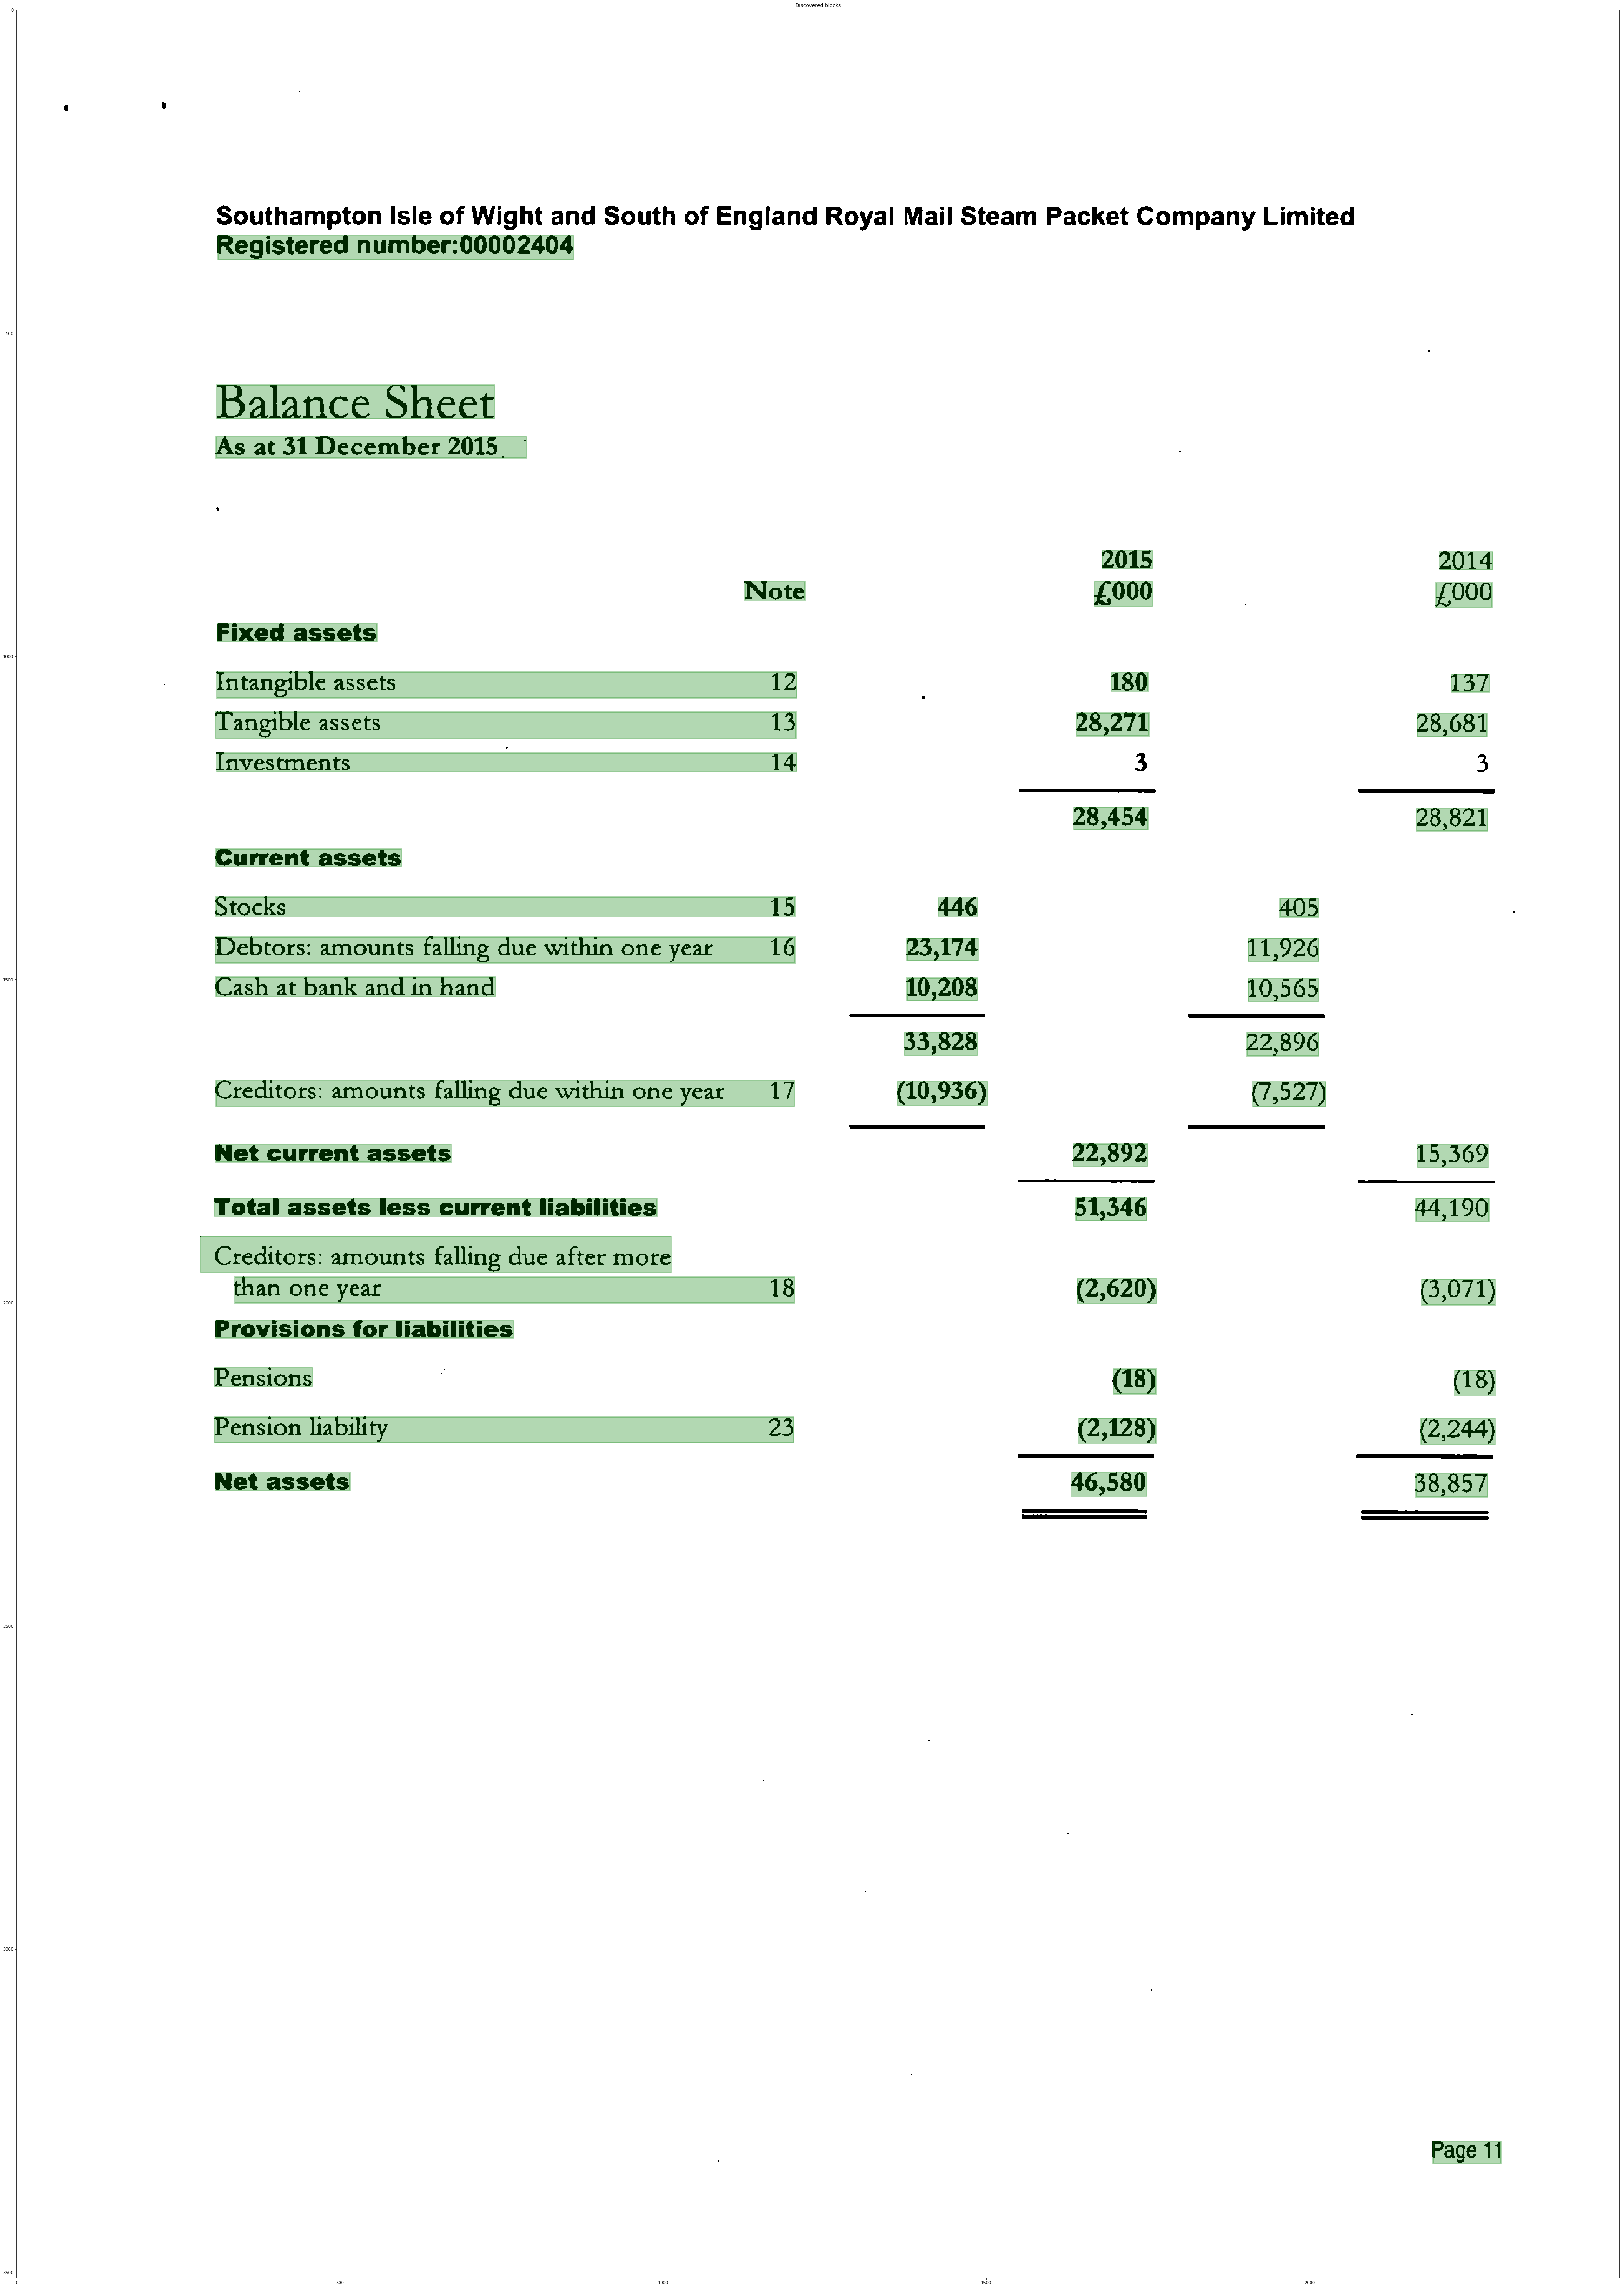

In [10]:
# Pick the file and page to plot
file_index=0
csv_num=14

# Pick the block level to portray
level=4

# Do all the maths
white_test=calculate_whitespace(xip.make_measurements(pd.read_csv("./working/ocr_output_compiled/"+files[file_index]+".csv")))

# Define the boxes to plot
path_patches, vertices = create_path_patches(white_test[white_test['level']==level], csv_num=csv_num)

# Draw everything up for inspection
plot_doc(path_patches, vertices, "./working/preprocessed/"+files[file_index]+"-"+str(csv_num)+".png")

# Apply code to all example PDF's

We'll output the results to a CSV file for evaluation later.

In [2]:
importlib.reload(xip)

# Get a list of all of the pdf files in the directory "example_data_PDF"
files = ["./example_data_PDF/"+filename for filename in os.listdir("./example_data_PDF") if ".pdf" in filename]

# Iterate through
results = pd.DataFrame()

for file in files[5:-1]:
    
    temp_df =  xip.process_PDF(file)
    temp_df['doc_companieshouseregisterednumber'] = file
    results = results.append( temp_df )
    print("Processed " + file)
        
    """except Exception as e:
        print("Failed to process " + file)
        print(e)"""

results.to_csv("example_extracted_PDF_data.csv")

./example_data_PDF/01804186.pdf
Converting PDF image to multiple png files
./example_data_PDF/02959325.pdf
Performing pre-processing on all png images
Processed ./example_data_PDF/02959325.pdf
Converting PDF image to multiple png files
./example_data_PDF/01539777.pdf
Performing pre-processing on all png images
Processed ./example_data_PDF/01539777.pdf
Converting PDF image to multiple png files
./example_data_PDF/1983517.pdf
Performing pre-processing on all png images
Processed ./example_data_PDF/1983517.pdf
Converting PDF image to multiple png files
./example_data_PDF/02266230.pdf
Performing pre-processing on all png images
Processed ./example_data_PDF/02266230.pdf
Converting PDF image to multiple png files
./example_data_PDF/983951.pdf
Performing pre-processing on all png images
Processed ./example_data_PDF/983951.pdf
Converting PDF image to multiple png files
./example_data_PDF/09457025.pdf
Performing pre-processing on all png images
Failed on ./example_data_PDF/09457025-24.png


KeyboardInterrupt: 